<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Xgboost_prophet_info%2Bpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Module

In [50]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

# xgboost라이브러리 추가
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from datetime import datetime

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#1.Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [63]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df = df.sort_values('date')
df = df.rename(columns ={'date':'ds'})
df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2019-01-01']
df = df.reset_index()
df  

,ds,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.0,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.1,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.5,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,101.55,69.0,52.16,5972.00,44.61,45.23,64.36,1271.0,1.41347,...,6584.700195,10381.509766,2488.830078,25478.880859,6579.490234,2028.439941,20077.619141,2937.360107,5597.200195,14165.200195
2918,2018-12-28,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2919,2018-12-29,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000
2920,2018-12-30,101.90,69.2,52.20,5992.25,45.33,45.34,62.63,1271.0,1.42140,...,6734.000000,10558.959961,2485.739990,25504.199219,6584.520020,2041.040039,20014.769531,2986.530029,5654.299805,14222.000000


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2922 non-null   datetime64[ns]
 1   Coal_price      2922 non-null   float64       
 2   iron            2922 non-null   float64       
 3   Brent_fut       2922 non-null   float64       
 4   copper_fut      2922 non-null   float64       
 5   WTI_fut         2922 non-null   float64       
 6   WTI             2922 non-null   float64       
 7   LNG_fut         2922 non-null   float64       
 8   bdi             2922 non-null   float64       
 9   USD/AUD(호주)     2922 non-null   float64       
 10  USD/CAD(캐나다)    2922 non-null   float64       
 11  USD/COP(콜롬비아)   2922 non-null   float64       
 12  US 달러지수         2922 non-null   float64       
 13  USD/IDR(인도네시아)  2922 non-null   float64       
 14  USD/RUB(러시아)    2922 non-null   float64       
 15  USD/

In [68]:
df_pred = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/prophet_pred/prophet_pred_all.csv", encoding = 'utf-8-sig')

df_pred['ds']= pd.to_datetime(df_pred['ds'])

df_pred = df_pred.set_index('ds')
df_pred = df_pred.reset_index()
df_pred

,ds,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2019-01-01,68.844687,74.522855,6338.449348,60.607189,60.575064,63.360254,1381.682968,1.406563,1.324021,...,7138.622840,11557.656351,2754.883974,27509.987943,7475.246958,2158.555002,22289.237440,3207.294033,5980.147840,15491.574898
1,2019-01-02,68.743551,74.996300,6328.466131,60.458968,60.424142,63.276945,1370.051570,1.405884,1.323644,...,7140.559256,11556.278493,2757.703402,27536.043607,7488.469204,2158.243920,22298.740508,3205.856078,5984.786085,15500.686341
2,2019-01-03,68.520474,75.284607,6323.487389,60.252915,60.242747,63.160457,1355.452987,1.406187,1.323195,...,7140.077111,11550.236164,2759.625660,27550.157941,7496.715561,2157.835060,22295.811253,3204.124995,5990.242953,15509.938682
3,2019-01-04,68.405736,75.557884,6324.902097,60.182117,60.174031,63.102454,1340.348076,1.406129,1.322845,...,7144.952006,11544.945422,2761.647753,27587.959076,7504.903712,2157.319356,22295.969776,3202.788429,5991.238556,15517.365113
4,2019-01-05,68.257358,75.762750,6320.396003,60.113034,60.119760,62.989985,1323.587394,1.405353,1.322406,...,7146.741329,11534.936465,2762.234293,27609.199789,7509.763807,2157.528226,22287.766273,3199.631211,5990.460013,15520.979191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,77.246685,76.092352,6325.620254,68.426871,68.485469,63.369587,1211.817052,1.390060,1.335157,...,7153.932812,11528.228283,2832.532487,28179.249191,7795.526890,2182.875432,22296.531669,3231.922322,6100.631687,15800.551991
86,2019-03-28,77.320475,75.990897,6311.844867,68.409800,68.486532,63.269052,1209.393201,1.391191,1.335022,...,7145.704217,11525.264561,2832.704929,28150.134478,7793.601086,2182.614449,22289.778329,3230.620326,6105.548485,15789.144645
87,2019-03-29,77.411569,76.026761,6304.315683,68.458903,68.536581,63.153897,1204.943404,1.392670,1.334989,...,7143.024739,11524.243394,2833.576042,28140.108298,7793.013401,2180.801668,22283.090047,3229.846418,6107.050565,15776.609238
88,2019-03-30,77.445115,76.046196,6293.877013,68.516909,68.609469,62.941070,1197.049379,1.394044,1.334703,...,7140.093860,11521.665939,2833.871374,28121.665598,7791.238220,2178.555499,22270.834705,3227.945072,6108.224352,15765.899223


In [54]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            90 non-null     datetime64[ns]
 1   Brent_fut       90 non-null     float64       
 2   iron            90 non-null     float64       
 3   copper_fut      90 non-null     float64       
 4   WTI_fut         90 non-null     float64       
 5   WTI             90 non-null     float64       
 6   LNG_fut         90 non-null     float64       
 7   bdi             90 non-null     float64       
 8   USD/AUD(호주)     90 non-null     float64       
 9   USD/CAD(캐나다)    90 non-null     float64       
 10  USD/COP(콜롬비아)   90 non-null     float64       
 11  US 달러지수         90 non-null     float64       
 12  USD/IDR(인도네시아)  90 non-null     float64       
 13  USD/RUB(러시아)    90 non-null     float64       
 14  USD/ZAR(자메이카)   90 non-null     float64       
 15  상하이종합지수 

In [55]:
df_pred.columns

Index(['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'],
      dtype='object')

In [56]:
df_merge = pd.merge(df, df_pred, on=['date', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수'], how='outer')
       
df_merge = df_merge[['date', 'Coal_price', 'Brent_fut', 'iron', 'copper_fut', 'WTI_fut', 'WTI', 'LNG_fut',
       'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)', 'US 달러지수',
       'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수', '인도지수',
       '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수', '나스닥지수',
       '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수']]
df_merge['date']= pd.to_datetime(df_merge['date'])

df_merge

,date,Coal_price,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,영국지수,독일지수,S&P500지수,항셍지수,나스닥지수,코스피지수,니케이225지수,유로스톡스50지수,호주지수,캐나다지수
0,2011-01-01,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,94.750000,168.300000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,94.840000,170.000000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,93.530000,172.100000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,95.500000,174.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,77.246685,76.092352,6325.620254,68.426871,68.485469,63.369587,1211.817052,1.390060,...,7153.932812,11528.228283,2832.532487,28179.249191,7795.526890,2182.875432,22296.531669,3231.922322,6100.631687,15800.551991
3008,2019-03-28,NaN,77.320475,75.990897,6311.844867,68.409800,68.486532,63.269052,1209.393201,1.391191,...,7145.704217,11525.264561,2832.704929,28150.134478,7793.601086,2182.614449,22289.778329,3230.620326,6105.548485,15789.144645
3009,2019-03-29,NaN,77.411569,76.026761,6304.315683,68.458903,68.536581,63.153897,1204.943404,1.392670,...,7143.024739,11524.243394,2833.576042,28140.108298,7793.013401,2180.801668,22283.090047,3229.846418,6107.050565,15776.609238
3010,2019-03-30,NaN,77.445115,76.046196,6293.877013,68.516909,68.609469,62.941070,1197.049379,1.394044,...,7140.093860,11521.665939,2833.871374,28121.665598,7791.238220,2178.555499,22270.834705,3227.945072,6108.224352,15765.899223


In [ ]:
# df_coal = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.csv", encoding = 'utf-8-sig')
# df_coal = df_coal.sort_values('date')
# df_coal['date']= pd.to_datetime(df_coal['date'])

# df_coal = df_coal.set_index('date')
# df_coal = df_coal[df_coal.index < '2019-04-01']
# df_coal = df_coal[df_coal.index >= '2019-01-01']
# df_coal = df_coal.reset_index()
# df_coal = df_coal[['date','Coal_price']]
# df_coal

,date,Coal_price
0,2019-01-01,102.05
1,2019-01-02,101.10
2,2019-01-03,99.60
3,2019-01-04,99.50
4,2019-01-05,99.50
...,...,...
85,2019-03-27,93.50
86,2019-03-28,92.95
87,2019-03-29,92.75
88,2019-03-30,92.75


#1.Data

*   df는 실제값으로 2018년도 12월 31일까지
*   df_pred는 prophet으로 prediction한 값 2019년부터 1월 1일까지 (Coal_price 제외)
*   df_merge에 예측에 필요한 coal_price값 제외하고 merge






In [57]:
df2 = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df2 = df2.sort_values('date')
df2['date']= pd.to_datetime(df2['date'])

df2 = df2.set_index('date')
df2 = df2[df2.index < '2019-01-01']
df2 = df2.reset_index()
df2 = df2[['date','Coal_price']] 
df2 = df2.rename(columns ={'date':'ds'})
df2

,ds,Coal_price
0,2011-01-01,122.65
1,2011-01-02,122.65
2,2011-01-03,136.50
3,2011-01-04,137.30
4,2011-01-05,130.65
...,...,...
2917,2018-12-27,101.55
2918,2018-12-28,101.90
2919,2018-12-29,101.90
2920,2018-12-30,101.90


In [58]:
# 컬럼명 변경
df2.columns = ['ds', 'y']

# 데이터 타입 변경
df2['ds']= pd.to_datetime(df2['ds'])

# 모델 생성
from fbprophet import Prophet
m = Prophet()

# 모델 학습
m.fit(df2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
forecast = m.predict(df2)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,128.980361,124.114522,136.120385,128.980361,128.980361,1.024081,1.024081,1.024081,-0.009050,-0.009050,-0.009050,1.033131,1.033131,1.033131,0.0,0.0,0.0,130.004442
1,2011-01-02,128.943999,123.857679,135.901284,128.943999,128.943999,1.199379,1.199379,1.199379,-0.004311,-0.004311,-0.004311,1.203689,1.203689,1.203689,0.0,0.0,0.0,130.143378
2,2011-01-03,128.907638,124.177834,136.145803,128.907638,128.907638,1.359033,1.359033,1.359033,-0.011905,-0.011905,-0.011905,1.370938,1.370938,1.370938,0.0,0.0,0.0,130.266671
3,2011-01-04,128.871276,124.337061,136.202888,128.871276,128.871276,1.570058,1.570058,1.570058,0.036721,0.036721,0.036721,1.533337,1.533337,1.533337,0.0,0.0,0.0,130.441335
4,2011-01-05,128.834915,124.300430,136.441722,128.834915,128.834915,1.692224,1.692224,1.692224,0.002844,0.002844,0.002844,1.689381,1.689381,1.689381,0.0,0.0,0.0,130.527139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,115.473699,109.480606,121.685928,115.473699,115.473699,0.164809,0.164809,0.164809,-0.018324,-0.018324,-0.018324,0.183133,0.183133,0.183133,0.0,0.0,0.0,115.638507
2918,2018-12-28,115.522634,109.944087,122.101147,115.522634,115.522634,0.352069,0.352069,0.352069,0.004025,0.004025,0.004025,0.348044,0.348044,0.348044,0.0,0.0,0.0,115.874703
2919,2018-12-29,115.571569,109.953329,121.560259,115.571569,115.571569,0.507786,0.507786,0.507786,-0.009050,-0.009050,-0.009050,0.516836,0.516836,0.516836,0.0,0.0,0.0,116.079355
2920,2018-12-30,115.620505,110.319554,121.799621,115.620505,115.620505,0.683907,0.683907,0.683907,-0.004311,-0.004311,-0.004311,0.688218,0.688218,0.688218,0.0,0.0,0.0,116.304412


In [64]:
df_merge2 = pd.merge(df,forecast)
df_merge2

,ds,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,-0.009050,-0.009050,-0.009050,1.033131,1.033131,1.033131,0.0,0.0,0.0,130.004442
1,2011-01-02,122.65,168.3,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,-0.004311,-0.004311,-0.004311,1.203689,1.203689,1.203689,0.0,0.0,0.0,130.143378
2,2011-01-03,136.50,170.0,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,-0.011905,-0.011905,-0.011905,1.370938,1.370938,1.370938,0.0,0.0,0.0,130.266671
3,2011-01-04,137.30,172.1,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,0.036721,0.036721,0.036721,1.533337,1.533337,1.533337,0.0,0.0,0.0,130.441335
4,2011-01-05,130.65,174.5,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,0.002844,0.002844,0.002844,1.689381,1.689381,1.689381,0.0,0.0,0.0,130.527139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,2018-12-27,101.55,69.0,52.16,5972.00,44.61,45.23,64.36,1271.0,1.41347,...,-0.018324,-0.018324,-0.018324,0.183133,0.183133,0.183133,0.0,0.0,0.0,115.638507
2918,2018-12-28,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,0.004025,0.004025,0.004025,0.348044,0.348044,0.348044,0.0,0.0,0.0,115.874703
2919,2018-12-29,101.90,69.2,52.20,5992.25,45.33,44.92,62.63,1271.0,1.42140,...,-0.009050,-0.009050,-0.009050,0.516836,0.516836,0.516836,0.0,0.0,0.0,116.079355
2920,2018-12-30,101.90,69.2,52.20,5992.25,45.33,45.34,62.63,1271.0,1.42140,...,-0.004311,-0.004311,-0.004311,0.688218,0.688218,0.688218,0.0,0.0,0.0,116.304412


In [65]:
last_1year = pd.date_range('2019-01-01', periods=90)
last_1year = list(last_1year)
last_1year = pd.DataFrame(last_1year, columns = ['ds'])
last_1year['ds']= pd.to_datetime(last_1year['ds'])

In [66]:
forecast1 = m.predict(last_1year)
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,115.718375,111.112989,122.803337,115.718375,115.718375,1.069852,1.069852,1.069852,0.036721,0.036721,0.036721,1.033131,1.033131,1.033131,0.0,0.0,0.0,116.788227
1,2019-01-02,115.767310,111.125871,123.180062,115.767310,115.767310,1.206533,1.206533,1.206533,0.002844,0.002844,0.002844,1.203689,1.203689,1.203689,0.0,0.0,0.0,116.973844
2,2019-01-03,115.816246,110.912752,123.267112,115.816246,115.816246,1.352614,1.352614,1.352614,-0.018324,-0.018324,-0.018324,1.370938,1.370938,1.370938,0.0,0.0,0.0,117.168860
3,2019-01-04,115.865181,111.318912,123.053002,115.865181,115.865181,1.537362,1.537362,1.537362,0.004025,0.004025,0.004025,1.533337,1.533337,1.533337,0.0,0.0,0.0,117.402543
4,2019-01-05,115.914116,111.585720,123.635685,115.914116,115.914116,1.680331,1.680331,1.680331,-0.009050,-0.009050,-0.009050,1.689381,1.689381,1.689381,0.0,0.0,0.0,117.594447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,119.877877,112.520976,125.521397,118.145885,121.651635,-1.103114,-1.103114,-1.103114,0.002844,0.002844,0.002844,-1.105958,-1.105958,-1.105958,0.0,0.0,0.0,118.774763
86,2019-03-28,119.926812,112.000216,125.129089,118.090904,121.751136,-1.203392,-1.203392,-1.203392,-0.018324,-0.018324,-0.018324,-1.185068,-1.185068,-1.185068,0.0,0.0,0.0,118.723420
87,2019-03-29,119.975747,111.648737,125.657508,118.084329,121.850834,-1.257456,-1.257456,-1.257456,0.004025,0.004025,0.004025,-1.261481,-1.261481,-1.261481,0.0,0.0,0.0,118.718291
88,2019-03-30,120.024683,112.312152,125.055347,118.076583,121.956890,-1.344562,-1.344562,-1.344562,-0.009050,-0.009050,-0.009050,-1.335512,-1.335512,-1.335512,0.0,0.0,0.0,118.680120


In [69]:
df_merge3 = pd.merge(df_pred,forecast1)
df_merge3

,ds,Brent_fut,iron,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),USD/CAD(캐나다),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,68.844687,74.522855,6338.449348,60.607189,60.575064,63.360254,1381.682968,1.406563,1.324021,...,0.036721,0.036721,0.036721,1.033131,1.033131,1.033131,0.0,0.0,0.0,116.788227
1,2019-01-02,68.743551,74.996300,6328.466131,60.458968,60.424142,63.276945,1370.051570,1.405884,1.323644,...,0.002844,0.002844,0.002844,1.203689,1.203689,1.203689,0.0,0.0,0.0,116.973844
2,2019-01-03,68.520474,75.284607,6323.487389,60.252915,60.242747,63.160457,1355.452987,1.406187,1.323195,...,-0.018324,-0.018324,-0.018324,1.370938,1.370938,1.370938,0.0,0.0,0.0,117.168860
3,2019-01-04,68.405736,75.557884,6324.902097,60.182117,60.174031,63.102454,1340.348076,1.406129,1.322845,...,0.004025,0.004025,0.004025,1.533337,1.533337,1.533337,0.0,0.0,0.0,117.402543
4,2019-01-05,68.257358,75.762750,6320.396003,60.113034,60.119760,62.989985,1323.587394,1.405353,1.322406,...,-0.009050,-0.009050,-0.009050,1.689381,1.689381,1.689381,0.0,0.0,0.0,117.594447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2019-03-27,77.246685,76.092352,6325.620254,68.426871,68.485469,63.369587,1211.817052,1.390060,1.335157,...,0.002844,0.002844,0.002844,-1.105958,-1.105958,-1.105958,0.0,0.0,0.0,118.774763
86,2019-03-28,77.320475,75.990897,6311.844867,68.409800,68.486532,63.269052,1209.393201,1.391191,1.335022,...,-0.018324,-0.018324,-0.018324,-1.185068,-1.185068,-1.185068,0.0,0.0,0.0,118.723420
87,2019-03-29,77.411569,76.026761,6304.315683,68.458903,68.536581,63.153897,1204.943404,1.392670,1.334989,...,0.004025,0.004025,0.004025,-1.261481,-1.261481,-1.261481,0.0,0.0,0.0,118.718291
88,2019-03-30,77.445115,76.046196,6293.877013,68.516909,68.609469,62.941070,1197.049379,1.394044,1.334703,...,-0.009050,-0.009050,-0.009050,-1.335512,-1.335512,-1.335512,0.0,0.0,0.0,118.680120


In [71]:
df_merge2.columns

Index(['ds', 'Coal_price', 'iron', 'Brent_fut', 'copper_fut', 'WTI_fut', 'WTI',
       'LNG_fut', 'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)',
       'US 달러지수', 'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수',
       '인도지수', '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수',
       '나스닥지수', '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수', 'trend',
       'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [115]:
df_merge4 = pd.merge(df_merge2, df_merge3, on=['ds', 'iron', 'Brent_fut', 'copper_fut', 'WTI_fut', 'WTI',
       'LNG_fut', 'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)',
       'US 달러지수', 'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수',
       '인도지수', '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수',
       '나스닥지수', '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수', 'trend',
       'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'], how='outer')
       
df_merge4 = df_merge4[['ds', 'Coal_price', 'iron', 'Brent_fut', 'copper_fut', 'WTI_fut', 'WTI',
       'LNG_fut', 'bdi', 'USD/AUD(호주)', 'USD/CAD(캐나다)', 'USD/COP(콜롬비아)',
       'US 달러지수', 'USD/IDR(인도네시아)', 'USD/RUB(러시아)', 'USD/ZAR(자메이카)', '상하이종합지수',
       '인도지수', '브라질지수', '다우존스지수', '프랑스지수', '영국지수', '독일지수', 'S&P500지수', '항셍지수',
       '나스닥지수', '코스피지수', '니케이225지수', '유로스톡스50지수', '호주지수', '캐나다지수', 'trend',
       'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat']]
df_merge4['ds']= pd.to_datetime(df_merge4['ds'])

df_merge4

,ds,Coal_price,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,bdi,USD/AUD(호주),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,122.65,168.300000,94.750000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,-0.009050,-0.009050,-0.009050,1.033131,1.033131,1.033131,0.0,0.0,0.0,130.004442
1,2011-01-02,122.65,168.300000,94.750000,9644.000000,91.380000,91.400000,61.070000,1773.000000,0.984470,...,-0.004311,-0.004311,-0.004311,1.203689,1.203689,1.203689,0.0,0.0,0.0,130.143378
2,2011-01-03,136.50,170.000000,94.840000,9644.000000,91.550000,91.560000,61.070000,1773.000000,0.979010,...,-0.011905,-0.011905,-0.011905,1.370938,1.370938,1.370938,0.0,0.0,0.0,130.266671
3,2011-01-04,137.30,172.100000,93.530000,9619.250000,89.380000,89.230000,58.320000,1693.000000,0.983370,...,0.036721,0.036721,0.036721,1.533337,1.533337,1.533337,0.0,0.0,0.0,130.441335
4,2011-01-05,130.65,174.500000,95.500000,9586.000000,90.300000,90.380000,56.400000,1621.000000,0.992850,...,0.002844,0.002844,0.002844,1.689381,1.689381,1.689381,0.0,0.0,0.0,130.527139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,NaN,76.092352,77.246685,6325.620254,68.426871,68.485469,63.369587,1211.817052,1.390060,...,0.002844,0.002844,0.002844,-1.105958,-1.105958,-1.105958,0.0,0.0,0.0,118.774763
3008,2019-03-28,NaN,75.990897,77.320475,6311.844867,68.409800,68.486532,63.269052,1209.393201,1.391191,...,-0.018324,-0.018324,-0.018324,-1.185068,-1.185068,-1.185068,0.0,0.0,0.0,118.723420
3009,2019-03-29,NaN,76.026761,77.411569,6304.315683,68.458903,68.536581,63.153897,1204.943404,1.392670,...,0.004025,0.004025,0.004025,-1.261481,-1.261481,-1.261481,0.0,0.0,0.0,118.718291
3010,2019-03-30,NaN,76.046196,77.445115,6293.877013,68.516909,68.609469,62.941070,1197.049379,1.394044,...,-0.009050,-0.009050,-0.009050,-1.335512,-1.335512,-1.335512,0.0,0.0,0.0,118.680120


In [116]:
df_merge4.isnull().sum()

ds                             0
Coal_price                    90
iron                           0
Brent_fut                      0
copper_fut                     0
WTI_fut                        0
WTI                            0
LNG_fut                        0
bdi                            0
USD/AUD(호주)                    0
USD/CAD(캐나다)                   0
USD/COP(콜롬비아)                  0
US 달러지수                        0
USD/IDR(인도네시아)                 0
USD/RUB(러시아)                   0
USD/ZAR(자메이카)                  0
상하이종합지수                        0
인도지수                           0
브라질지수                          0
다우존스지수                         0
프랑스지수                          0
영국지수                           0
독일지수                           0
S&P500지수                       0
항셍지수                           0
나스닥지수                          0
코스피지수                          0
니케이225지수                       0
유로스톡스50지수                      0
호주지수                           0
캐나다지수     

In [117]:
df = pd.read_excel("/content/gdrive/My Drive/Black_coal/data/dataset/project_dataset.xlsx")
df1 = df.sort_values('date')
df1['date']= pd.to_datetime(df1['date'])


df1 = df1[['date','Coal_price']] 
df1 = df1.rename(columns ={'date':'ds'})
df1 = df1.set_index('ds')
df1 = df1[df1.index >= '2019-01-01']
df1 = df1[df1.index < '2019-04-01']
df1 = df1.reset_index()
df1

,ds,Coal_price
0,2019-01-01,102.05
1,2019-01-02,101.10
2,2019-01-03,99.60
3,2019-01-04,99.50
4,2019-01-05,99.50
...,...,...
85,2019-03-27,93.50
86,2019-03-28,92.95
87,2019-03-29,92.75
88,2019-03-30,92.75


#2.Train/Test

In [118]:

df_merge4 = df_merge4.set_index('ds')
# 학습과 테스트 데이터 분리
split = "2017-12-31"
df_train = df_merge4[:split]
df_test = df_merge4[split:'2018-12-31']
df_predict = df_merge4['2019-01-01':]

df_train_y = df_train.loc[:,'Coal_price']
df_train_x = df_train.drop('Coal_price', axis=1)
df_test_y = df_test.loc[:,'Coal_price']
df_test_x = df_test.drop('Coal_price', axis=1)
# 나중에 예측값과 비교하기 위해 test 데이터 복제본 저장
df_test_orig = df1.loc[:, 'Coal_price']
df_predict_x = df_predict.drop('Coal_price', axis=1)
df_predict_x = df_predict_x['2019-01-01':]



#3.Model

##3.0 Max_depth 10

[09:43:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


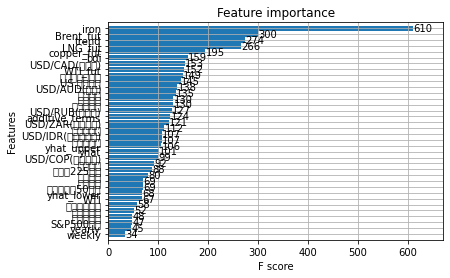

In [119]:

XG_model_month = xgb.XGBRegressor(learning_rate=0.1,max_depth=6,n_estimators=200)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

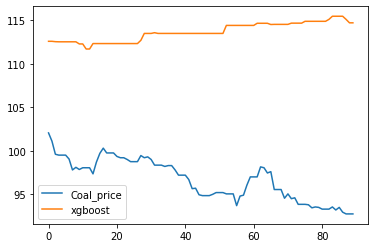

In [120]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]
result.plot()

##3.1 Max_depth 20

[09:44:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


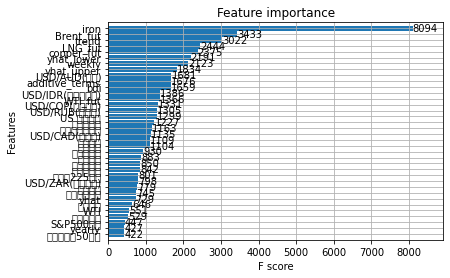

In [121]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 20)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

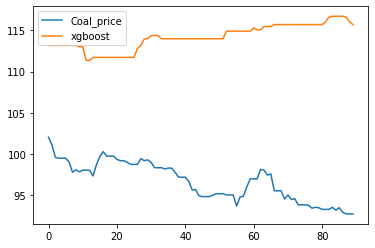

In [122]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]
result.plot()

##3.2 Max_depth 30

[09:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


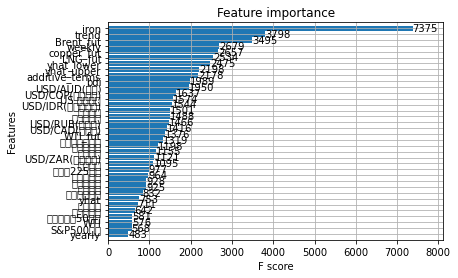

In [123]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000, max_depth= 30)
XG_model_month.fit(df_train_x, df_train_y, eval_set=[(df_test_x, df_test_y)], early_stopping_rounds=100,verbose=False)

# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

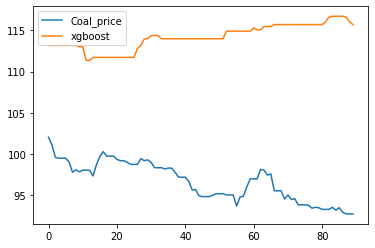

In [124]:
# 테스트 데이터 중 특정 store/item 데이터를 추출


xgboost = XG_model_month.predict(df_predict_x)

# 실제 값과 예측 값을 하나의 DataFrame으로 만들고 visualize
result=pd.concat([df_test_orig.reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
# result = result.set_index('date')
result = result.loc[:, ['Coal_price', 'xgboost']]
result.plot()

In [ ]:
# y_pred = y_tt['y_pred'].values
# y_true = df_test_orig['Coal_price'].values
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# mae = mean_absolute_error(y_true, y_pred)
# mape = mean_absolute_percentage_error(y_true, y_pred)

# print('MAE: %.3f' % mae)
# print('MAPE: %.3f' % mape)
# plt.plot(y_true, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.legend()
# plt.show()

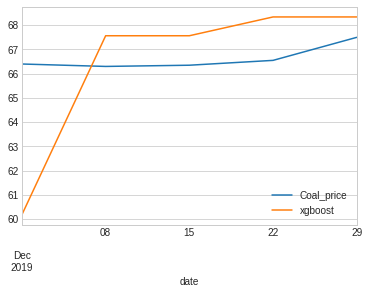

#4.Evaluation